<a href="https://colab.research.google.com/github/amaye15/CanineNet/blob/main/ModelFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install datasets==2.16.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


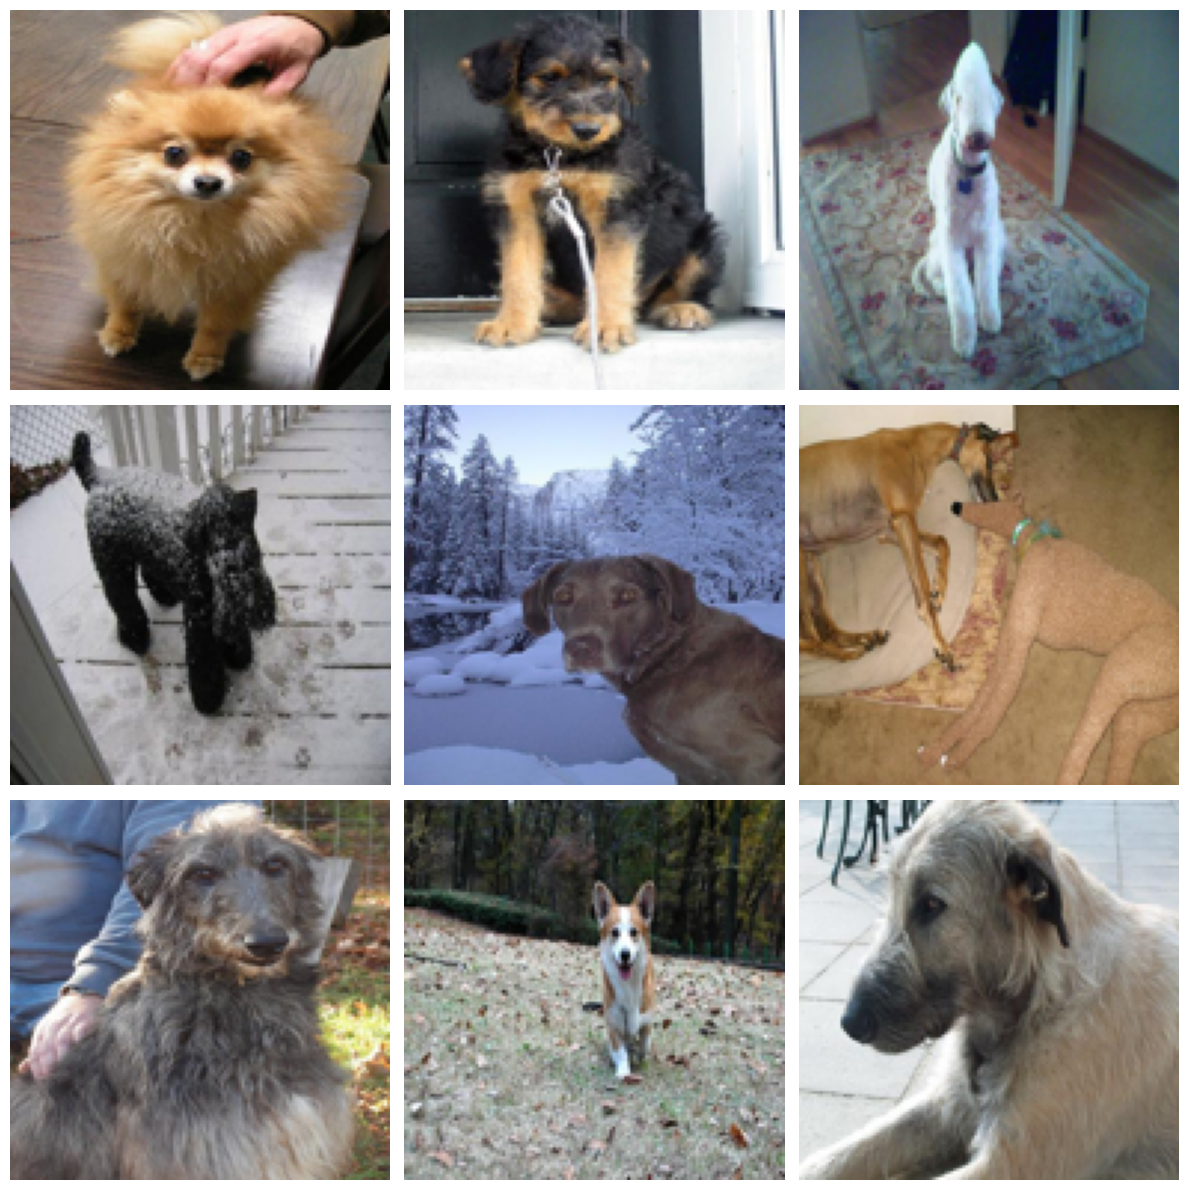

In [21]:
import io
import cv2
import datasets
import torch

from PIL import Image
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pyarrow_hotfix

from functools import partial


pyarrow_hotfix.uninstall()
# Load the dataset
dataset = datasets.load_dataset("Alanox/stanford-dogs", split="full")


def display_random_images(dataset, key = "image", number_of_images=9, image_size=(128, 128), grid_size=(3, 3)):
    """
    Displays a specified number of random images from a Hugging Face dataset in a grid layout.

    Parameters:
    dataset: The dataset to use.
    number_of_images (int): The number of images to display.
    image_size (tuple): The size (width, height) to which each image will be resized.
    grid_size (tuple): The grid size (rows, columns) for displaying the images.
    """

    # Shuffle the dataset
    shuffled_dataset = dataset.shuffle(seed=np.random.randint(0, 1000))

    # Determine the number of rows and columns in the grid
    rows, cols = grid_size

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, ax in enumerate(axes):
        if i < number_of_images:
            # Decode and resize the image
            image_data = shuffled_dataset[i][key]
            image = image_data
            image = image.resize(image_size)

            # Display the image
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide extra subplots if the number of images is less than grid cells
            ax.axis('off')

    plt.tight_layout()
    plt.show()


#display_random_images(dataset)

In [38]:
import numpy as np
import itertools
from torchvision.transforms import Compose, ColorJitter, Grayscale, GaussianBlur, Resize
from torchvision.transforms.functional import equalize

# Define ranges for each parameter using numpy.arange
brightness_options = np.arange(0.5, 2.0, 0.5)
contrast_options = np.arange(0.25, 1.0, 0.25)
saturation_options = np.arange(0.25, 1.0, 0.25)
hue_options = np.arange(0.25, 0.75, 0.25)
blur_kernel_sizes = np.arange(5, 20, 2)  # Only odd integers

# Define resize options
resize_options = [(128, 128), (256, 256), (64, 64), (512, 512)]

# Generate all combinations including resize options
all_combinations = itertools.product(
    brightness_options, contrast_options, saturation_options,
    hue_options, blur_kernel_sizes, resize_options
)

# Iterate over each combination
for idx, combo in enumerate(all_combinations):
    brightness, contrast, saturation, hue, blur_size, resize_dim = combo

    transformation = Compose([
        ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
        Grayscale(),
        GaussianBlur(int(blur_size)),
        equalize,
        Resize(resize_dim)
    ])

    if idx == 2: break

    # Apply the transformation and evaluate (pseudo-code)
    # transformed_data = transformation(your_data)
    # performance = evaluate_model(your_model, transformed_data)
    # Record the performance along with the parameter combination



In [39]:
def transforms(examples, transformation_function):
    examples["image transformed"] = [transformation_function(image.convert("RGB")) for image in examples["image"]]
    return examples

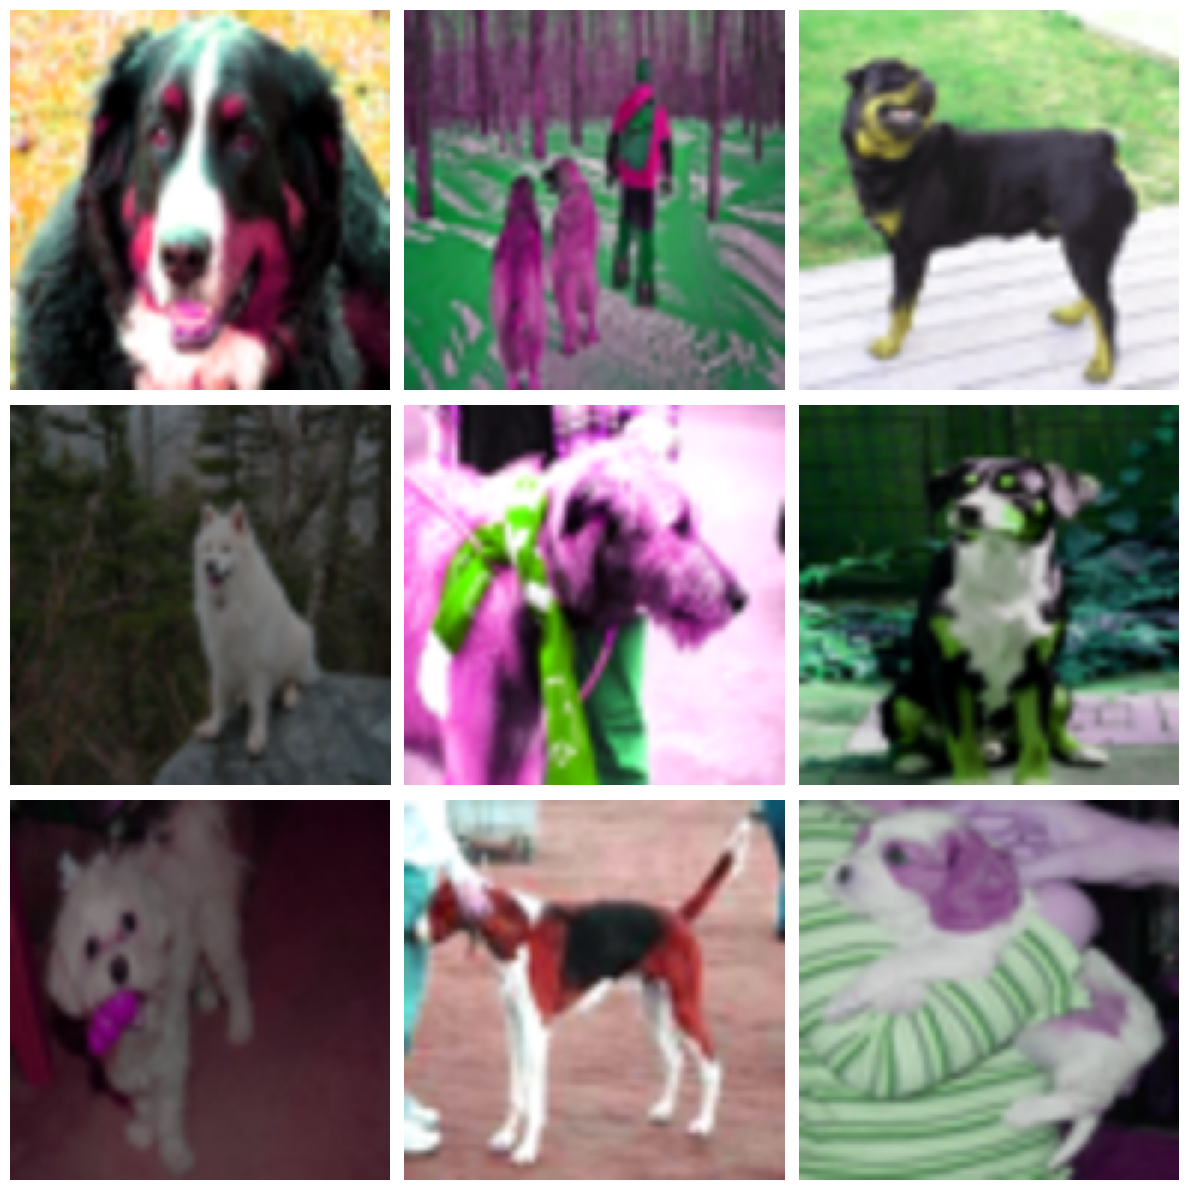

In [40]:
dataset.set_transform(partial(transforms, transformation_function = transformation))
display_random_images(dataset, key = "image transformed")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, conv_layers, fc_layers, input_size, dropout_rates=None, activation_fn=F.relu, pool_fn=nn.MaxPool2d(kernel_size=2, stride=2)):
        super(CNN, self).__init__()
        self.activation_fn = activation_fn
        self.pool_fn = pool_fn

        self.conv_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        last_channels = input_size[0]
        output_size = input_size[1:]

        for i, (in_channels, out_channels, kernel_size, padding) in enumerate(conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            output_size = [((size + 2 * padding - (kernel_size - 1) - 1) // 2) + 1 for size in output_size]  # Calculate output size
            last_channels = out_channels
            if dropout_rates and i < len(dropout_rates):
                self.dropouts.append(nn.Dropout(dropout_rates[i]))
            else:
                self.dropouts.append(nn.Identity())  # No dropout

        flatten_size = last_channels * output_size[0] * output_size[1]
        self.fc_layers = nn.ModuleList()
        for out_features in fc_layers:
            self.fc_layers.append(nn.Linear(flatten_size, out_features))
            flatten_size = out_features

    def forward(self, x):
        for conv, dropout in zip(self.conv_layers, self.dropouts):
            x = dropout(self.pool_fn(self.activation_fn(conv(x))))

        x = x.view(x.size(0), -1)  # Flatten

        for i, fc in enumerate(self.fc_layers):
            x = self.activation_fn(fc(x))
            if i < len(self.fc_layers) - 1:
                x = self.dropouts[i](x)  # Apply corresponding dropout

        return x

# Example usage
model = CNN(
    conv_layers=[(3, 32, 3, 1), (32, 64, 3, 1), (64, 32, 3, 1), (32, 16, 3, 1)],
    fc_layers=[128, 1],
    input_size=(3, 224, 224),  # Assuming input size of 224x224 with 3 channels
    dropout_rates=[0.25, 0.25, 0.5]
)

output = model(torch.randn(32, 3, 224, 224))  # Example input tensor



In [ ]:
model

CNN(
  (pool_fn): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.25, inplace=False)
    (2): Dropout(p=0.5, inplace=False)
    (3): Identity()
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)